In [1]:
import warnings
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.model_selection import train_test_split
import umap

/home/amirreza/micromamba/envs/nadetox/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def find_best_num_cluster(data, initial_umap_clusters=5, min_clusters=2, max_clusters=10):
    '''
    This function is to find the best number of clusters for the umap clustering
    pass the full set of data_x (train + test) to the function. **not data_y**
    '''
    # Create a UMAP reducer
    reducer = umap.UMAP(n_neighbors=initial_umap_clusters, n_components=2, random_state=42)

    # Apply UMAP to the data
    embedding = reducer.fit_transform(data)

    # Create a DataFrame for the embedding
    umap_df = pd.DataFrame(embedding, columns=['UMAP_1', 'UMAP_2'])

    # store the results in a dictionary
    results_dict = {'n_clusters': [], 'silhouette_score': [], 'davies_bouldin_score': []}
    for n_clusters in range(min_clusters, max_clusters):
        kmeans = KMeans(n_clusters=n_clusters, random_state=60)
        umap_df['Cluster'] = kmeans.fit_predict(embedding)
        silhouette_avg = silhouette_score(embedding, kmeans.labels_)
        db_index = davies_bouldin_score(embedding, kmeans.labels_)
        results_dict['n_clusters'].append(n_clusters)
        results_dict['silhouette_score'].append(silhouette_avg)
        results_dict['davies_bouldin_score'].append(db_index)

        
    # return the row with the maximum difference
    cluster_results = pd.DataFrame(results_dict)
    cluster_results['difference'] = cluster_results['silhouette_score'] - cluster_results['davies_bouldin_score']
    # show the row with the maximum difference
    cluster_results.sort_values(by='difference', ascending=False, inplace=True)
    best_no_cluster = cluster_results.head(1).n_clusters.values[0]
    print(f"best number of clusters: {best_no_cluster}")
    return best_no_cluster, cluster_results

def umap_clustering(data, initial_umap_clusters=5, min_clusters=2, max_clusters=10) -> pd.DataFrame:
    # find the best number of clusters
    best_no_cluster, cluster_results = find_best_num_cluster(data, initial_umap_clusters=5, min_clusters=2, max_clusters=10)
    # now dow the umap clustering with the best number of clusters
    reducer = umap.UMAP(n_neighbors=best_no_cluster, n_components=2, random_state=42)
    embedding = reducer.fit_transform(data)
    umap_df = pd.DataFrame(embedding, columns=['UMAP_1', 'UMAP_2'])
    # use Kmins to cluster the umap embedding
    kmeans = KMeans(n_clusters=best_no_cluster, random_state=60)
    umap_df['Cluster'] = kmeans.fit_predict(embedding)
    # umap_df['value'] = data_y
    return umap_df


def cluster_split(umap_df, data_x, data_y, test_size=0.2, plot=True, verbose=False):

    '''
    This function is to split the data into train and test for each cluster
    '''
    train_list = []
    test_list = []

    # Loop over each cluster
    for cluster_id, cluster_data in umap_df.groupby('Cluster'):
        if verbose:
            print(f"cluster {cluster_id} has {len(cluster_data)} samples")

        train_part, test_part = train_test_split(
            cluster_data,
            test_size=test_size,          # 20% test split
            random_state=42,        # reproducibility
            shuffle=True
        )
        if len(cluster_data) <= 5:
            print(f"cluster {cluster_id} has less than 5 samples, so it is not used for splitting")
            train_part = cluster_data
            # test_part = pd.DataFrame()
            train_list.append(train_part)
        else:
            train_list.append(train_part)
            # print(f"train part has {len(train_part)} samples")
            test_list.append(test_part)
            # print(f"test part has {len(test_part)} samples")

    # Concatenate all cluster splits
    umap_df_train = pd.concat(train_list)
    umap_df_test = pd.concat(test_list)
    # get the index of the original data_x
    train_df_x = data_x.iloc[umap_df_train.index]
    test_df_x = data_x.iloc[umap_df_test.index]
    train_df_y = data_y.iloc[umap_df_train.index]
    test_df_y = data_y.iloc[umap_df_test.index]
    # show only 3 digits after the decimal point
    print(f"train test ratio: {round(len(test_df_x) / (len(train_df_x) + len(test_df_x)) * 100, 3)}% for test set")
    if plot:
        # plot the umap clustering with respect to train and test
        plt.figure(figsize=(10, 8))
        sns.scatterplot(x='UMAP_1', y='UMAP_2', data=umap_df_train, color='blue', alpha=0.7, s=50)
        sns.scatterplot(x='UMAP_1', y='UMAP_2', data=umap_df_test, color='red', alpha=0.7, s=50)
        plt.title("UMAP Clustering with KMeans", fontsize=16)
        plt.xlabel("UMAP Dimension 1")
        plt.ylabel("UMAP Dimension 2")
        plt.legend(title='Legend', labels=['Train', 'Test'])
        plt.savefig(f'umap_clustering_train_test.png')
        plt.show()
    return train_df_x, test_df_x, train_df_y, test_df_y

In [3]:
def split_x_y(data):
  X = data.drop(columns=['value'])
  y = data['value']
  return X, y

# functions to preprocess the data
def normalize_data(xtrain, xtest):
    scaler = StandardScaler()
    scaler.fit(xtrain)
    xtrain_norm = scaler.transform(xtrain)
    xtest_norm = scaler.transform(xtest)
    xtest_norm = pd.DataFrame(xtest_norm,columns=xtest.columns)
    xtrain_norm = pd.DataFrame(xtrain_norm,columns=xtrain.columns)
    return xtrain_norm, xtest_norm

def remove_constant_features(xtrain, xtest):
    xtrain_constant = xtrain.loc[:, xtrain.nunique() == 1]
    xtrain = xtrain.drop(columns=xtrain_constant.columns)
    xtest = xtest[xtrain.columns]
    return xtrain, xtest

def remove_highly_correlated_features(xtrain, xtest, threshold=0.95):
    corr_matrix = xtrain.corr()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    xtrain = xtrain.drop(columns=to_drop)
    xtest = xtest[xtrain.columns]
    return xtrain, xtest

def remove_low_variance_features(xtrain, xtest, threshold=0.01):
    xtrain_variance = xtrain.var()
    xtest_variance = xtest.var()
    xtrain = xtrain.loc[:, xtrain_variance > threshold]
    xtest = xtest[xtrain.columns]
    return xtrain, xtest

best number of clusters: 2
train test ratio: 21.875% for test set


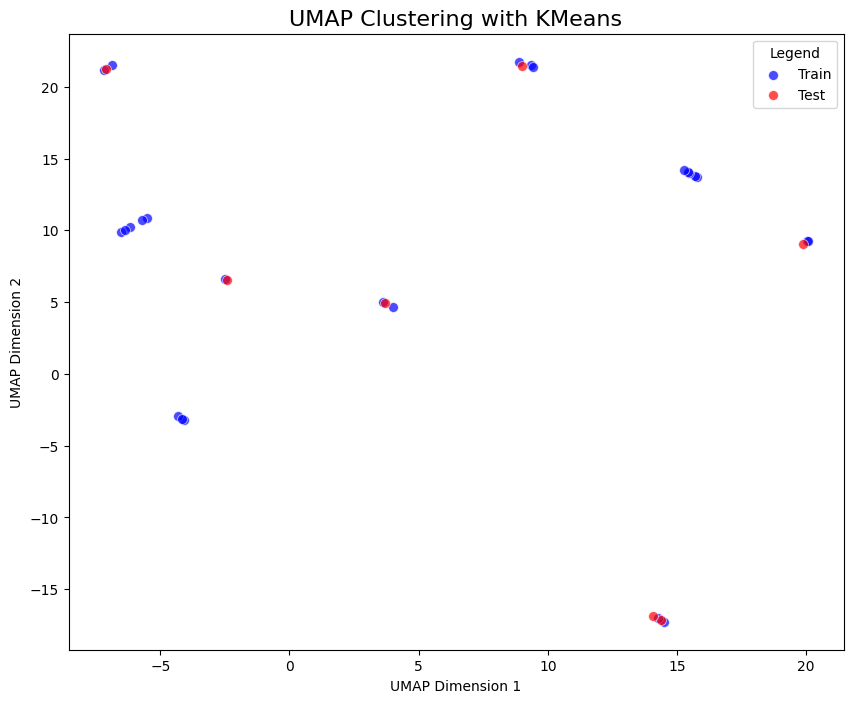

number of descriptors in the train set: 134
training set size: 25
test set size: 7


In [ ]:
# ignore the warnings

warnings.filterwarnings('ignore')
# read the data
data = pd.read_csv('sample_data.csv')
# split the data
data_x, data_y = split_x_y(data)
# do umap clustering on X data 
# this function find the best number of clusters for the umap clustering
# but needs some initial number of clusters to start with. 
# for example, here the initial number of clusters is 5. you can change it to any between min and max clusters.
umap_df = umap_clustering(data_x, initial_umap_clusters=5, min_clusters=2, max_clusters=10)
# split the data into train and test for each cluster
X_train, X_test, y_train, y_test = cluster_split(umap_df, data_x, data_y, test_size=0.2, plot=True, verbose=False)

# preprocess the data
X_train, X_test = normalize_data(X_train, X_test)
X_train, X_test = remove_constant_features(X_train, X_test)
X_train, X_test = remove_highly_correlated_features(X_train, X_test, threshold=0.95)
X_train, X_test = remove_low_variance_features(X_train, X_test, threshold=0.01)
 
print(f"number of descriptors in the train set: {X_train.shape[1]}")
print(f"training set size: {X_train.shape[0]}")
print(f"test set size: {X_test.shape[0]}")
# save the splitted and preprocessed data
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

# once you have these X_train, X_test, y_train, y_test, you can run the ga_feature_selection_regression.py 
# which uses the genetic algorithm to select the best features for a given regression model.
